In [1]:
import pandas as pd
import os, sys
from collections import Counter
import geopandas as gpd
import pylab as pl
from fiona.crs import from_epsg
import shapely 
import seaborn as sns
from shapely.geometry import Point
import pyproj

% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Turn RDD output into orderly dataframe

In [2]:
df = pd.read_csv('/Users/shay/CUSP/BDM/results.csv', index_col = 0)
df.columns = ['Date_Hour', 'Results']

df['Results'] = df['Results'].apply(lambda x: eval(x))

final = pd.DataFrame()
for row in range(len(df)):
    tempdf = pd.DataFrame.from_dict(df.Results[row], orient = 'index')
    tempdf.reset_index(inplace = True)
    tempdf.columns = ['Station', 'Taxi_Rides']
    tempdf['Date_Hour'] = df.Date_Hour[row]
    final = final.append(tempdf)

final.reset_index(inplace = True, drop=True)
final['Date'] = final['Date_Hour'].apply(lambda x: x.split(', ')[0][1:])
final['Hour'] = final['Date_Hour'].apply(lambda x: x.split(', ')[1][:-1])
final['Station'] = final['Station'].convert_objects(convert_numeric = True)
final['Station'] = final['Station'].apply(lambda x: int(x))
final.drop('Date_Hour', axis = 1, inplace = True)

final.to_csv('finaldf.csv')

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [3]:
len(final)

69710

# Merge with subway delay data

In [4]:
df95 = pd.read_csv('/Users/shay/CUSP/BDM/subway_taxi_project/merged_4_30.csv')

final['keycol'] = final.Station.map(lambda x: str(x) + '_') + \
                final.Date.map(lambda x: str(x) + '_') + \
                final.Hour.map(lambda x: str(x))

merged = final.merge(df95, left_on = 'keycol', right_on = 'keycol', how = 'right')

merged.set_index('keycol', inplace = True)

# Read in subway shapefile, create 300 foot buffer

In [8]:
merged = pd.read_csv('/Users/shay/CUSP/BDM/subway_taxi_project/merged_4_30.csv')

In [9]:
filepath = '/Users/shay/CUSP/BDM/subway_taxi_project/data/subwaystations/subwaystations.shp'
subwayst = gpd.read_file(filepath)

In [10]:
subwayst.crs = from_epsg(4326)
subwayst = subwayst.to_crs(epsg = 2263)

In [11]:
subwayst['buffer'] = subwayst.geometry.apply(lambda x: x.buffer(300))
subwayst.set_geometry('buffer', crs = 2263, inplace = True)

# Attach shapes to DataFrame

In [12]:
subwayst.objectid = subwayst.objectid.map(lambda x: int(x))

In [13]:
subwaytaxi = subwayst.merge(merged, left_on = 'objectid', right_on = 'Station', how = 'right')

# Some Visualizations

In [14]:
viz_df = subwaytaxi.groupby('Station').mean()
viz_df = viz_df.merge(subwayst)

In [15]:
viz_df.drop(['geometry', 'notes', 'url'], axis = 1, inplace = True)

In [16]:
viz_df = gpd.GeoDataFrame(viz_df, geometry = 'buffer')

/Users/shay/anaconda2/lib/python2.7/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "percentages". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)


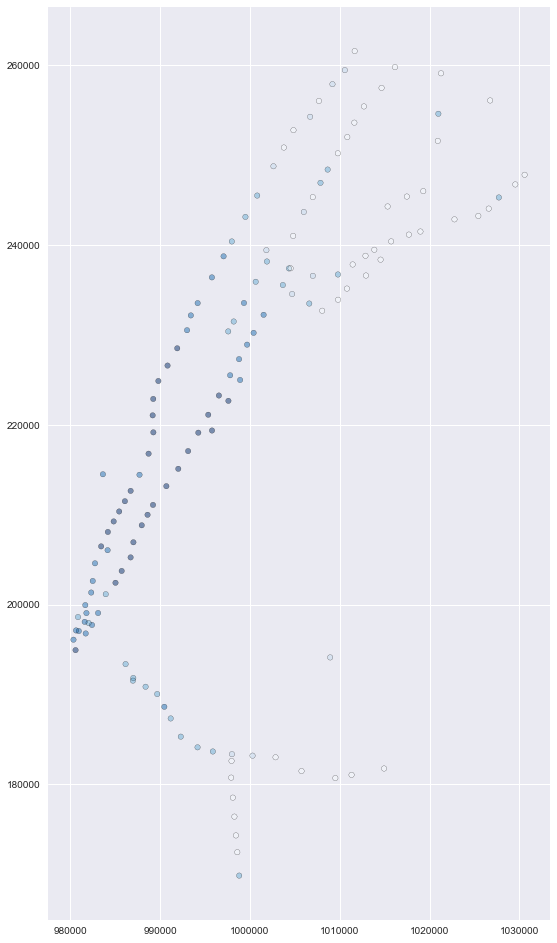

In [17]:
viz_df.plot('Taxi_Rides', figsize = (9, 20), cmap = cm.Blues, scheme = 'percentages', linewidth = .2)

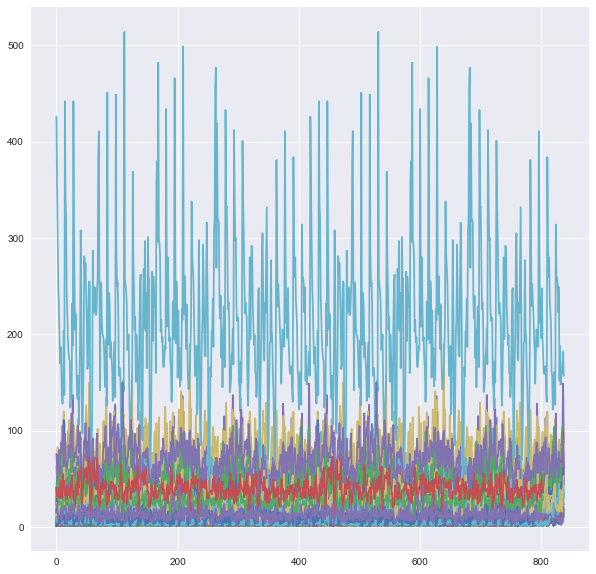

In [18]:
merged.sort_values(['Date', 'Hour'], inplace = True)
fig = pl.figure(figsize(10, 10))
for station in subwaytaxi.objectid.unique():
    filterd = subwaytaxi[subwaytaxi.objectid == station]
    pl.plot(range(len(filterd)), filterd.Taxi_Rides, label = filterd.name.iloc[0])

In [19]:
avgsdf = subwaytaxi.groupby('Station').mean().sort_values('Taxi_Rides', ascending = False)

In [24]:
subwaytaxi['nameline'] = subwaytaxi['name'] + subwaytaxi['line']

In [25]:
withdelays = subwaytaxi[subwaytaxi.delay > 0].groupby('nameline')[['Taxi_Rides', 'nameline']].mean().sort_values('Taxi_Rides', ascending = False)

In [26]:
nodelays = subwaytaxi[subwaytaxi.delay == 0].groupby('nameline')[['Taxi_Rides', 'nameline']].mean().sort_values('Taxi_Rides', ascending = False)

In [27]:
comparison = withdelays.merge(nodelays, left_index = True, right_index = True, suffixes = ('_with', '_without'))

In [28]:
comparison[comparison.Taxi_Rides_with > comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
nameline,,
59th St - Columbus Circle1-2,75.653595,73.605263
51st St4-6-6 Express,55.548387,50.206780
Lexington Ave - 59th St4-5-6-6 Express,53.401639,49.528620
86th StQ,40.164179,39.626866
23rd St1-2,37.428571,35.478469
Union Sq - 14th St4-5-6-6 Express,36.863636,33.993958
79th St1-2,33.405660,33.294686
50th St1-2,33.078947,31.266376
96th St1-2-3,29.246377,28.597865


In [29]:
comparison[comparison.Taxi_Rides_with < comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
nameline,,
34th St - Penn Station1-2-3,206.011494,218.069388
86th St4-5-6-6 Express,64.469697,74.216028
Grand Central - 42nd St4-5-6-6 Express,55.023529,58.742515
72nd St1-2-3,52.109091,52.566929
28th St4-6-6 Express,46.805556,49.701681
66th St - Lincoln Ctr1-2,49.061321,49.611650
23rd St4-6-6 Express,43.844828,48.269388
33rd St4-6-6 Express,37.148810,47.972112
28th St1-2,36.812183,37.441441


In [30]:
subwaytaxi['delayed'] = subwaytaxi.delay.apply(lambda x: 1 if x > 0 else 0)

In [31]:
vizdf2 = subwayst.merge(subwaytaxi.groupby(['nameline', 'delayed']).mean(), how = 'right')

In [134]:
comparison['percchange'] = ((comparison['Taxi_Rides_with'] - comparison['Taxi_Rides_without']) / \
                            comparison['Taxi_Rides_without'] ) * 100
comparison.fillna(0, inplace = True)

In [135]:
vizdf3 = subwaytaxi.groupby('nameline').mean().merge(comparison, right_index = True, left_index = True)

In [136]:
vizdf3 = vizdf3.merge(subwayst, how='left')

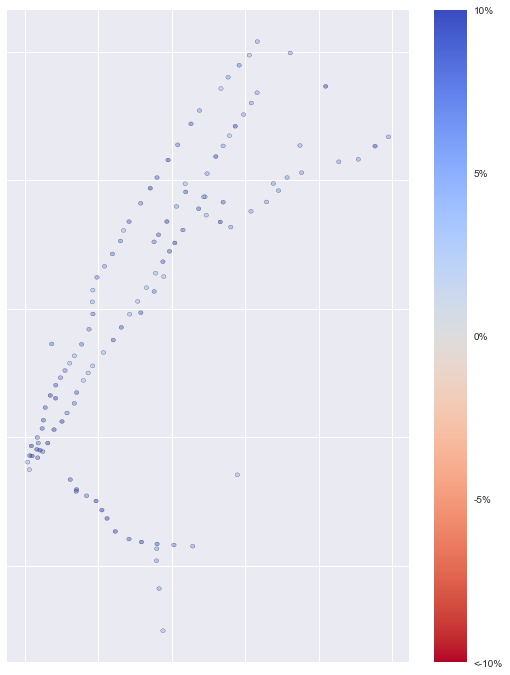

In [164]:
fig, ax = pl.subplots(figsize = (9, 12))

vizdf3 = gpd.GeoDataFrame(vizdf3, geometry = 'buffer')

vmax = 10
vmin = -10
vizdf3.plot('percchange', cmap = cm.coolwarm_r, scheme = 'quantiles', linewidth = .2,
           vmin = vmin, ax = ax)

m = cm.ScalarMappable(cmap=cm.coolwarm_r)
m.set_array(np.linspace(vmin, vmax, 200))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')

cbar = fig.colorbar(m)
cbar.set_ticks([vmin, -5, 0, 5, vmax])
cbar.set_ticklabels(['<-10%', '-5%', '0%', '5%', '10%'])

In [166]:
morningcommute = subwaytaxi[subwaytaxi.Hour < 11]

In [177]:
eveningcommute = subwaytaxi[subwaytaxi.Hour > 17][subwaytaxi.Hour < 20]

/Users/shay/anaconda2/lib/python2.7/site-packages/geopandas/geodataframe.py:376: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [171]:
from scipy.stats import ttest_ind

In [237]:
stations = morningcommute.Station.unique()
mornres = []
everes = []
mornstat = []
evestat = []
for station in stations: 
    a = morningcommute[morningcommute.Station == station][morningcommute.delayed == 1].Taxi_Rides
    b = morningcommute[morningcommute.Station == station][morningcommute.delayed == 0].Taxi_Rides
    c = eveningcommute[eveningcommute.Station == station][eveningcommute.delayed == 1].Taxi_Rides
    d = eveningcommute[eveningcommute.Station == station][eveningcommute.delayed == 0].Taxi_Rides
    morntest = ttest_ind(a, b, equal_var=0)
    evetest = ttest_ind(c, d, equal_var = 0)
    mornres.append(morntest.pvalue)
    everes.append(evetest.pvalue)
    mornstat.append(morntest.statistic)
    evestat.append(evetest.statistic)

In [238]:
mornres = np.array(mornres)
everes = np.array(everes)
mornstat = np.array(mornstat)
evestat = np.array(evestat)

In [239]:
resdf = pd.DataFrame({'station': stations,
                      'mornres': mornres,
                      'mornstat': mornstat,
                      'everes': everes,
                      'evestat': evestat})

In [240]:
results = resdf.merge(subwaytaxi, left_on = 'station', right_on='objectid')

In [241]:
resdf.dropna(inplace = True)

In [242]:
results = resdf.merge(subwaytaxi.groupby('nameline', as_index = False).mean()[['objectid', 'nameline']], 
                      left_on = 'station', right_on = 'objectid', how = 'left')

In [246]:
results[results.mornres < 0.025][results.mornstat > 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,everes,evestat,mornres,mornstat,station,objectid,nameline
3,0.002655,3.078443,0.000011,4.503743,29,29.0,Brooklyn Bridge - City Hall4-5-6-6 Express
68,0.171788,-1.375913,0.000043,4.228275,450,450.0,110th St4-6-6 Express


In [245]:
results[results.everes < 0.025][results.evestat > 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,everes,evestat,mornres,mornstat,station,objectid,nameline
3,2.654562e-03,3.078443,1.130341e-05,4.503743,29,29.0,Brooklyn Bridge - City Hall4-5-6-6 Express
11,3.864793e-03,3.786042,9.852052e-01,-0.018643,84,84.0,W 4th St - Washington Sq (Lower)B-D-F-M
27,7.154881e-08,7.318291,4.530153e-05,-4.430073,141,141.0,138th St - Grand Concourse4-5
49,3.780827e-03,3.014471,6.924045e-12,-7.342110,358,358.0,34th St - Penn Station1-2-3
66,0.000000e+00,inf,4.246319e-02,2.160247,445,445.0,Nostrand Ave3-4


In [247]:
mergedttest = comparison.merge(results, right_on = 'nameline', left_index = True )

In [250]:
mergedttest[mergedttest.everes < 0.025][results.evestat > 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,everes,evestat,mornres,mornstat,station,objectid,nameline
49,206.011494,218.069388,-5.529384,3.780827e-03,3.014471,6.924045e-12,-7.342110,358,358.0,34th St - Penn Station1-2-3
11,11.388060,9.394030,21.226565,3.864793e-03,3.786042,9.852052e-01,-0.018643,84,84.0,W 4th St - Washington Sq (Lower)B-D-F-M
3,8.839552,6.514286,35.694881,2.654562e-03,3.078443,1.130341e-05,4.503743,29,29.0,Brooklyn Bridge - City Hall4-5-6-6 Express
27,1.437500,1.337349,7.488739,7.154881e-08,7.318291,4.530153e-05,-4.430073,141,141.0,138th St - Grand Concourse4-5
66,1.142857,1.000000,14.285714,0.000000e+00,inf,4.246319e-02,2.160247,445,445.0,Nostrand Ave3-4


In [251]:
mergedttest[mergedttest.mornres < 0.025][results.mornstat > 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,everes,evestat,mornres,mornstat,station,objectid,nameline
3,8.839552,6.514286,35.694881,0.002655,3.078443,0.000011,4.503743,29,29.0,Brooklyn Bridge - City Hall4-5-6-6 Express
68,3.616667,3.277778,10.338983,0.171788,-1.375913,0.000043,4.228275,450,450.0,110th St4-6-6 Express


In [252]:
mergedttest[mergedttest.everes < 0.025][results.evestat < 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,everes,evestat,mornres,mornstat,station,objectid,nameline
45,46.805556,49.701681,-5.827016,0.000848,-3.425877,9.781863e-09,-5.993542,200,200.0,28th St4-6-6 Express
10,53.401639,49.528620,7.819761,0.001539,-3.283369,1.749146e-02,-2.411620,49,49.0,Lexington Ave - 59th St4-5-6-6 Express
16,43.844828,48.269388,-9.166390,0.002659,-3.071443,1.053735e-14,-8.766597,92,92.0,23rd St4-6-6 Express
5,37.148810,47.972112,-22.561654,0.002082,-3.148041,1.212935e-12,-7.882626,32,32.0,33rd St4-6-6 Express
7,29.440559,35.804348,-17.773787,0.007456,-2.734809,6.995866e-11,-7.199614,34,34.0,77th St4-6-6 Express
21,36.863636,33.993958,8.441732,0.024959,-2.298217,1.122442e-02,-2.684723,105,105.0,Union Sq - 14th St4-5-6-6 Express
42,33.405660,33.294686,0.333310,0.024113,-2.298953,1.099033e-01,1.606916,193,193.0,79th St1-2
20,22.753425,27.117647,-16.093662,0.000821,-3.464656,2.246205e-09,-6.491946,102,102.0,68th St - Hunter College4-6-6 Express
70,22.198630,22.190476,0.036745,0.006566,-2.768044,3.409309e-06,-4.959472,457,457.0,Bleecker St4-6-6 Express
53,14.023622,13.904110,0.859548,0.016594,-2.467012,1.883715e-03,-3.165575,404,404.0,Chambers St1-2-3


In [254]:
mergedttest[mergedttest.mornres < 0.025][results.mornstat < 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,everes,evestat,mornres,mornstat,station,objectid,nameline
49,206.011494,218.069388,-5.529384,3.780827e-03,3.014471,6.924045e-12,-7.342110,358,358.0,34th St - Penn Station1-2-3
69,64.469697,74.216028,-13.132380,9.666955e-02,-1.681338,2.086506e-06,-5.112355,451,451.0,86th St4-5-6-6 Express
4,55.023529,58.742515,-6.330995,3.887058e-02,-2.123276,4.679418e-08,-6.542106,31,31.0,Grand Central - 42nd St4-5-6-6 Express
45,46.805556,49.701681,-5.827016,8.483217e-04,-3.425877,9.781863e-09,-5.993542,200,200.0,28th St4-6-6 Express
14,49.061321,49.611650,-1.109275,3.518921e-01,0.936594,2.322050e-02,-2.284929,88,88.0,66th St - Lincoln Ctr1-2
10,53.401639,49.528620,7.819761,1.538849e-03,-3.283369,1.749146e-02,-2.411620,49,49.0,Lexington Ave - 59th St4-5-6-6 Express
16,43.844828,48.269388,-9.166390,2.659112e-03,-3.071443,1.053735e-14,-8.766597,92,92.0,23rd St4-6-6 Express
5,37.148810,47.972112,-22.561654,2.082096e-03,-3.148041,1.212935e-12,-7.882626,32,32.0,33rd St4-6-6 Express
7,29.440559,35.804348,-17.773787,7.456070e-03,-2.734809,6.995866e-11,-7.199614,34,34.0,77th St4-6-6 Express
18,37.428571,35.478469,5.496580,4.283446e-02,2.048531,9.596540e-05,-3.971861,96,96.0,23rd St1-2


In [ ]:
# create categorical
# 1 = significant (and higher)
# 2 = significant (and lower)
# 3 else 0

In [275]:
mornsig = np.zeros(len(mergedttest))
evesig = np.zeros(len(mergedttest))
sigeve = mergedttest[mergedttest.everes < 0.025][results.evestat < 0]
sigmorn = mergedttest[mergedttest.mornres < 0.025][results.mornstat < 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [267]:
mergedttest[mergedttest['mornres'] < 0.025][results['mornstat'] < 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,everes,evestat,mornres,mornstat,station,objectid,nameline
49,206.011494,218.069388,-5.529384,3.780827e-03,3.014471,6.924045e-12,-7.342110,358,358.0,34th St - Penn Station1-2-3
69,64.469697,74.216028,-13.132380,9.666955e-02,-1.681338,2.086506e-06,-5.112355,451,451.0,86th St4-5-6-6 Express
4,55.023529,58.742515,-6.330995,3.887058e-02,-2.123276,4.679418e-08,-6.542106,31,31.0,Grand Central - 42nd St4-5-6-6 Express
45,46.805556,49.701681,-5.827016,8.483217e-04,-3.425877,9.781863e-09,-5.993542,200,200.0,28th St4-6-6 Express
14,49.061321,49.611650,-1.109275,3.518921e-01,0.936594,2.322050e-02,-2.284929,88,88.0,66th St - Lincoln Ctr1-2
10,53.401639,49.528620,7.819761,1.538849e-03,-3.283369,1.749146e-02,-2.411620,49,49.0,Lexington Ave - 59th St4-5-6-6 Express
16,43.844828,48.269388,-9.166390,2.659112e-03,-3.071443,1.053735e-14,-8.766597,92,92.0,23rd St4-6-6 Express
5,37.148810,47.972112,-22.561654,2.082096e-03,-3.148041,1.212935e-12,-7.882626,32,32.0,33rd St4-6-6 Express
7,29.440559,35.804348,-17.773787,7.456070e-03,-2.734809,6.995866e-11,-7.199614,34,34.0,77th St4-6-6 Express
18,37.428571,35.478469,5.496580,4.283446e-02,2.048531,9.596540e-05,-3.971861,96,96.0,23rd St1-2
